# Load libraries

In [11]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"
!pip install -qq gym==0.23.0
from typing import Tuple, Dict, Optional, Iterable
import numpy as np
import matplotlib
from matplotlib import animation
from IPython.display import HTML
from IPython import display
import gym
from gym import spaces
from gym.error import DependencyNotInstalled
import pygame
from pygame import gfxdraw
import matplotlib.pyplot as plt
from pickle import FALSE

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Training Environment

In [13]:
class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False, shaped_rewards: bool = False, size: int = 10) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards

        # For agent1
        self.agent1 = (0, 0)
        self.goal1 = (9, 9)
        self.obj1 = (6, 4)

         # For agent2
        self.agent2 = (2,2)
        self.goal2 = (2, 3)
        self.obj2 = (7, 0)

        # For agent3
        self.agent3 = (0, 9)
        self.goal3 = (9,0)
        self.obj3 = (5, 9)


        self.maze = self._create_maze(size=size)
        self.distances1_1 = self._compute_distances(self.obj1, self.maze)
        self.distances2_1 = self._compute_distances(self.obj2, self.maze)
        self.distances3_1 = self._compute_distances(self.obj3, self.maze)
        self.distances1_2 = self._compute_distances(self.goal1, self.maze)
        self.distances2_2 = self._compute_distances(self.goal2, self.maze)
        self.distances3_2 = self._compute_distances(self.goal3, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}    # 4 actions
        self.observation_space = spaces.MultiDiscrete([size, size])
        self.screen = None
        self.agent_transform = None
        self.pickup1 = False
        self.pickup2 = False
        self.pickup3 = False

    # Step for agent1
    def reset1(self, id: int) -> Tuple[int, int]:
        if id == 0:
          self.pickup1 = False
          if self.exploring_starts:
              while self.agent1 == self.obj1:
                  self.agent1 = tuple(self.observation_space.sample())
          else:
              self.agent1 = (0, 0)
        else:
          self.pickup1 = True
          if self.exploring_starts:
              while self.agent1 == self.goal1:
                  self.agent1 = tuple(self.observation_space.sample())
          else:
              self.agent1 = (1, 2)
        return self.agent1

    def step1(self,action : int) -> Tuple[Tuple[int, int], float, bool, Dict]:

      reward1 = self.compute_reward1(self.agent1, action)
      self.agent1 = self._get_next_state(self.agent1, action)

      if not self.pickup1:
          done1 = self.agent1 == self.obj1
      else:
        done1 = self.agent1 == self.goal1
      info = {}
      return self.agent1, reward1, done1, info

    def isPickup1(self) -> bool:
        return True if self.agent1 == self.obj1 else False

    def compute_reward1(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if not self.pickup1:
          if self.shaped_rewards:
              return - (self.distances1_1[next_state] / self.distances1_1.max())
          return - float(state != self.obj1)
        else:
          if self.shaped_rewards:
              return - (self.distances1_2[next_state] / self.distances1_2.max())
          return - float(state != self.goal1)

    def simulate_step1(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward1(state, action)
        next_state = self._get_next_state(state, action)
        if not self.pickup1:
          done = next_state == self.obj1
        else:
          done = next_state == self.goal1
        info = {}
        return next_state, reward, done, info

    # For agent 2
    def reset2(self, id: int) -> Tuple[int, int]:
        if id == 0:
          self.pickup2 = False
          if self.exploring_starts:
              while self.agent2 == self.obj2:
                  self.agent2 = tuple(self.observation_space.sample())
          else:
              self.agent2 = (2,2)
        else:
          self.pickup2 = True
          if self.exploring_starts:
              while self.agent2 == self.goal2:
                  self.agent2 = tuple(self.observation_space.sample())
          else:
              self.agent2 = (1,1)
        return self.agent2

    def step2(self,action : int) -> Tuple[Tuple[int, int], float, bool, Dict]:
      reward2 = self.compute_reward2(self.agent2, action)
      self.agent2 = self._get_next_state(self.agent2, action)

      if not self.pickup2:
          done2 = self.agent2 == self.obj2
      else:
        done2 = self.agent2 == self.goal2
      info = {}
      return self.agent2, reward2, done2, info

    def isPickup2(self) -> bool:
        return True if self.agent2 == self.obj2 else False

    def compute_reward2(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if not self.pickup2:
          if self.shaped_rewards:
              return - (self.distances2_1[next_state] / self.distances2_1.max())
          return - float(state != self.obj2)
        else:
          if self.shaped_rewards:
              return - (self.distances2_2[next_state] / self.distances2_2.max())
          return - float(state != self.goal2)

    def simulate_step2(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward2(state, action)
        next_state = self._get_next_state(state, action)
        if not self.pickup2:
          done = next_state == self.obj2
        else:
          done = next_state == self.goal2
        info = {}
        return next_state, reward, done, info

#######################################################################################
    # For agent 3
    def reset3(self, id: int) -> Tuple[int, int]:
        if id == 0:
            self.pickup3 = False
            if self.exploring_starts:
                while self.agent3 == self.obj3:
                    self.agent3 = tuple(self.observation_space.sample())
            else:
                self.agent3 = (0, 9)
        else:
            self.pickup3 = True
            if self.exploring_starts:
                while self.agent3 == self.goal3:
                    self.agent3 = tuple(self.observation_space.sample())
            else:
                self.agent3 = (8, 9)
        return self.agent3

    def step3(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward3 = self.compute_reward3(self.agent3, action)
        self.agent3 = self._get_next_state(self.agent3, action)

        if not self.pickup3:
            done3 = self.agent3 == self.obj3
        else:
            done3 = self.agent3 == self.goal3
        info = {}
        return self.agent3, reward3, done3, info

    def isPickup3(self) -> bool:
        return True if self.agent3 == self.obj3 else False

    def compute_reward3(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if not self.pickup3:
            if self.shaped_rewards:
                return - (self.distances3_1[next_state] / self.distances3_1.max())
            return - float(state != self.obj3)
        else:
            if self.shaped_rewards:
                return - (self.distances3_2[next_state] / self.distances3_2.max())
            return - float(state != self.goal3)


    def simulate_step3(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward3(state, action)
        next_state = self._get_next_state(state, action)
        if not self.pickup3:
            done = next_state == self.obj3
        else:
            done = next_state == self.goal3
        info = {}
        return next_state, reward, done, info


# For Overall functions

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1,0),(1,1)],[(2,0),(2,1)],[(3,0),(3,1)],[(0,1),(1,1)],[(0,2),(1,2)],[(0,2),(0,3)],
            [(1,3),(1,4)],[(1,4),(2,4)],[(0,5),(1,5)],[(0,5),(0,6)],[(1,5),(1,6)],
            [(0,7),(1,7)],[(0,8),(1,8)],[(0,9),(1,9)],
            [(2,6),(2,7)],[(2,7),(2,8)],[(2,8),(2,9)],[(2,7),(3,7)],[(1,8),(2,8)],
            [(3,2),(3,3)],[(4,2),(4,3)],[(5,2),(5,3)],[(2,3),(3,3)],[(2,4),(3,4)],
            [(7,0),(8,0)],[(7,0),(7,1)],[(6,0),(6,1)],[(5,1),(6,1)],[(6,1),(6,2)],[(7,1),(7,2)],[(8,1),(8,2)],[(8,1),(9,1)],
            [(5,4),(5,5)],[(6,4),(6,5)],[(6,4),(7,4)],
            [(5,5),(5,6)],[(4,5),(4,6)],[(3,6),(4,6)],[(3,7),(4,7)],[(3,8),(4,8)],[(3,9),(4,9)],
            # [(5,7),(5,8)],[(5,8),(5,9)],[(6,7),(5,8)],[(5,8),(6,8)],
            [(9,8),(9,9)],[(8,8),(8,9)],
            [(8,4),(9,4)],[(8,5),(9,5)],[(8,6),(9,6)],[(8,7),(9,7)],[(8,6),(8,7)],[(7,6),(7,7)],
            [(5,7),(5,8)],[(5,8),(5,9)],[(7,8),(6,8)],[(6,8),(6,9)],[(5,9),(6,9)]

        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((10 ,10), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 10, v % 10) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances

# Rendering Function
    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
      assert mode in ['human', 'rgb_array']

      screen_size = 600
      scale = screen_size / 10

      if self.screen is None:
          pygame.init()
          self.screen = pygame.Surface((screen_size, screen_size))

      surf = pygame.Surface((screen_size, screen_size))
      surf.fill((22, 36, 71))

      # Draw the grid and walls
      for row in range(10):
          for col in range(10):
              state = (row, col)
              for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (10 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (10 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))



      # Draw the agent1
      agent_row = int(screen_size - scale * (self.agent1[0] + 0.5))
      agent_col = int(scale * (self.agent1[1] + 0.5))
      gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * 0.6 / 2), (228, 63, 90))

      # Draw the goal1
      goal_left, goal_right, goal_top, goal_bottom = scale * 9 + 10, scale * 10 - 10, scale - 10, 10
      gfxdraw.filled_polygon(surf, [(goal_left, goal_bottom), (goal_left, goal_top), (goal_right, goal_top), (goal_right, goal_bottom)], (40, 199, 172))

      # Draw the object1
      object_size = int(scale * 0.4)

      if not self.pickup1:
          self.pickup1 = self.isPickup1()

      if not self.pickup1:
          # Object remains in its fixed position (1, 2) before pickup
          object_row = int(screen_size - scale * (self.obj1[0] + 0.5))  # Fixed at row 1
          object_col = int(scale * (self.obj1[1] + 0.5))  # Fixed at column 2
          gfxdraw.box(surf, (object_col - object_size // 2, object_row - object_size // 2, object_size, object_size), (255, 165, 0))
      else:
          # Object moves dynamically with the agent after pickup
          object_left = agent_col - object_size // 2
          object_top = agent_row - object_size // 2
          gfxdraw.box(surf, (object_left, object_top, object_size, object_size), (255, 165, 0))

##############################
      # Draw the agent2
      agent_row = int(screen_size - scale * (self.agent2[0] + 0.5))
      agent_col = int(scale * (self.agent2[1] + 0.5))
      gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * 0.6 / 2), (255, 255, 255))

      # Draw the goal2 at (2, 3)
      goal_row, goal_col = 2, 3  # New goal position
      goal_left = int(goal_col * scale + 10)  # Left boundary
      goal_right = int((goal_col + 1) * scale - 10)  # Right boundary
      goal_top = int(screen_size - (goal_row + 1) * scale + 10)  # Top boundary
      goal_bottom = int(screen_size - goal_row * scale - 10)  # Bottom boundary

      gfxdraw.filled_polygon(
          surf,
          [(goal_left, goal_bottom), (goal_left, goal_top), (goal_right, goal_top), (goal_right, goal_bottom)],
          (255, 192, 203)
      )

      # Draw the object2
      object_size2 = int(scale * 0.4)

      if not self.pickup2:
          self.pickup2 = self.isPickup2()

      if not self.pickup2:
          # Object remains in its fixed position (1, 2) before pickup
          object_row = int(screen_size - scale * (self.obj2[0] + 0.5))  # Fixed at row 1
          object_col = int(scale * (self.obj2[1] + 0.5))  # Fixed at column 2
          gfxdraw.box(surf, (object_col - object_size2 // 2, object_row - object_size2 // 2, object_size2, object_size2), (128, 0, 128))
      else:
          # Object moves dynamically with the agent after pickup
          object_left = agent_col - object_size2 // 2
          object_top = agent_row - object_size2 // 2
          gfxdraw.box(surf, (object_left, object_top, object_size2, object_size2), (128, 0, 128))


##############################
      # Draw the agent3
      agent_row = int(screen_size - scale * (self.agent3[0] + 0.5))
      agent_col = int(scale * (self.agent3[1] + 0.5))
      gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * 0.6 / 2), (0, 255, 255)) # aqua

      # Draw the goal3
      goal_row, goal_col = self.goal3[0], self.goal3[1]  # New goal position
      goal_left = int(goal_col * scale + 10)  # Left boundary
      goal_right = int((goal_col + 1) * scale - 10)  # Right boundary
      goal_top = int(screen_size - (goal_row + 1) * scale + 10)  # Top boundary
      goal_bottom = int(screen_size - goal_row * scale - 10)  # Bottom boundary

      gfxdraw.filled_polygon(
          surf,
          [(goal_left, goal_bottom), (goal_left, goal_top), (goal_right, goal_top), (goal_right, goal_bottom)],
          (224, 255, 255) # Light Cyan
      )
      # Draw the object2
      object_size3 = int(scale * 0.4)

      if not self.pickup3:
          self.pickup3 = self.isPickup3()

      if not self.pickup3:
          # Object remains in its position before pickup
          object_row = int(screen_size - scale * (self.obj3[0] + 0.5))  # Fixed at row 1
          object_col = int(scale * (self.obj3[1] + 0.5))  # Fixed at column 2
          gfxdraw.box(surf, (object_col - object_size3 // 2, object_row - object_size3 // 2, object_size3, object_size3), (150, 75, 0)) # Mint Cream
      else:
          # Object moves dynamically with the agent after pickup
          object_left = agent_col - object_size3 // 2
          object_top = agent_row - object_size3 // 2
          gfxdraw.box(surf, (object_left, object_top, object_size3, object_size3), (150, 75, 0))

#########################


      surf = pygame.transform.flip(surf, False, True)
      self.screen.blit(surf, (0, 0))

      if mode == 'human':
          pygame.display.flip()
      elif mode == 'rgb_array':
          return np.transpose(
              np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2))

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

In [14]:
import seaborn as sns
def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(20,6))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 10}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()

def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(20, 6))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 10}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()

def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)

def plot_action_values(action_values):

    text_positions = [
        # First layout
        [(0.35, 9.75), (1.35, 9.75), (2.35, 9.75), (3.35, 9.75), (4.35, 9.75), (5.35, 9.75), (6.35, 9.75), (7.35, 9.75), (8.35, 9.75), (9.35, 9.75),
        (0.35, 8.75), (1.35, 8.75), (2.35, 8.75), (3.35, 8.75), (4.35, 8.75), (5.35, 8.75), (6.35, 8.75), (7.35, 8.75), (8.35, 8.75), (9.35, 8.75),
        (0.35, 7.75), (1.35, 7.75), (2.35, 7.75), (3.35, 7.75), (4.35, 7.75), (5.35, 7.75), (6.35, 7.75), (7.35, 7.75), (8.35, 7.75), (9.35, 7.75),
        (0.35, 6.75), (1.35, 6.75), (2.35, 6.75), (3.35, 6.75), (4.35, 6.75), (5.35, 6.75), (6.35, 6.75), (7.35, 6.75), (8.35, 6.75), (9.35, 6.75),
        (0.35, 5.75), (1.35, 5.75), (2.35, 5.75), (3.35, 5.75), (4.35, 5.75), (5.35, 5.75), (6.35, 5.75), (7.35, 5.75), (8.35, 5.75), (9.35, 5.75),
        (0.35, 4.75), (1.35, 4.75), (2.35, 4.75), (3.35, 4.75), (4.35, 4.75), (5.35, 4.75), (6.35, 4.75), (7.35, 4.75), (8.35, 4.75), (9.35, 4.75),
        (0.35, 3.75), (1.35, 3.75), (2.35, 3.75), (3.35, 3.75), (4.35, 3.75), (5.35, 3.75), (6.35, 3.75), (7.35, 3.75), (8.35, 3.75), (9.35, 3.75),
        (0.35, 2.75), (1.35, 2.75), (2.35, 2.75), (3.35, 2.75), (4.35, 2.75), (5.35, 2.75), (6.35, 2.75), (7.35, 2.75), (8.35, 2.75), (9.35, 2.75),
        (0.35, 1.75), (1.35, 1.75), (2.35, 1.75), (3.35, 1.75), (4.35, 1.75), (5.35, 1.75), (6.35, 1.75), (7.35, 1.75), (8.35, 1.75), (9.35, 1.75),
        (0.35, 0.75), (1.35, 0.75), (2.35, 0.75), (3.35, 0.75), (4.35, 0.75), (5.35, 0.75), (6.35, 0.75), (7.35, 0.75), (8.35, 0.75), (9.35, 0.75)],

        # Second layout
        [(0.6, 9.45), (1.6, 9.45), (2.6, 9.45), (3.6, 9.45), (4.6, 9.45), (5.6, 9.45), (6.6, 9.45), (7.6, 9.45), (8.6, 9.45), (9.6, 9.45),
        (0.6, 8.45), (1.6, 8.45), (2.6, 8.45), (3.6, 8.45), (4.6, 8.45), (5.6, 8.45), (6.6, 8.45), (7.6, 8.45), (8.6, 8.45), (9.6, 8.45),
        (0.6, 7.45), (1.6, 7.45), (2.6, 7.45), (3.6, 7.45), (4.6, 7.45), (5.6, 7.45), (6.6, 7.45), (7.6, 7.45), (8.6, 7.45), (9.6, 7.45),
        (0.6, 6.45), (1.6, 6.45), (2.6, 6.45), (3.6, 6.45), (4.6, 6.45), (5.6, 6.45), (6.6, 6.45), (7.6, 6.45), (8.6, 6.45), (9.6, 6.45),
        (0.6, 5.45), (1.6, 5.45), (2.6, 5.45), (3.6, 5.45), (4.6, 5.45), (5.6, 5.45), (6.6, 5.45), (7.6, 5.45), (8.6, 5.45), (9.6, 5.45),
        (0.6, 4.45), (1.6, 4.45), (2.6, 4.45), (3.6, 4.45), (4.6, 4.45), (5.6, 4.45), (6.6, 4.45), (7.6, 4.45), (8.6, 4.45), (9.6, 4.45),
        (0.6, 3.45), (1.6, 3.45), (2.6, 3.45), (3.6, 3.45), (4.6, 3.45), (5.6, 3.45), (6.6, 3.45), (7.6, 3.45), (8.6, 3.45), (9.6, 3.45),
        (0.6, 2.45), (1.6, 2.45), (2.6, 2.45), (3.6, 2.45), (4.6, 2.45), (5.6, 2.45), (6.6, 2.45), (7.6, 2.45), (8.6, 2.45), (9.6, 2.45),
        (0.6, 1.45), (1.6, 1.45), (2.6, 1.45), (3.6, 1.45), (4.6, 1.45), (5.6, 1.45), (6.6, 1.45), (7.6, 1.45), (8.6, 1.45), (9.6, 1.45),
        (0.6, 0.45), (1.6, 0.45), (2.6, 0.45), (3.6, 0.45), (4.6, 0.45), (5.6, 0.45), (6.6, 0.45), (7.6, 0.45), (8.6, 0.45), (9.6, 0.45)],

        # Third layout
        [(0.35, 9.15), (1.35, 9.15), (2.35, 9.15), (3.35, 9.15), (4.35, 9.15), (5.35, 9.15), (6.35, 9.15), (7.35, 9.15), (8.35, 9.15), (9.35, 9.15),
        (0.35, 8.15), (1.35, 8.15), (2.35, 8.15), (3.35, 8.15), (4.35, 8.15), (5.35, 8.15), (6.35, 8.15), (7.35, 8.15), (8.35, 8.15), (9.35, 8.15),
        (0.35, 7.15), (1.35, 7.15), (2.35, 7.15), (3.35, 7.15), (4.35, 7.15), (5.35, 7.15), (6.35, 7.15), (7.35, 7.15), (8.35, 7.15), (9.35, 7.15),
        (0.35, 6.15), (1.35, 6.15), (2.35, 6.15), (3.35, 6.15), (4.35, 6.15), (5.35, 6.15), (6.35, 6.15), (7.35, 6.15), (8.35, 6.15), (9.35, 6.15),
        (0.35, 5.15), (1.35, 5.15), (2.35, 5.15), (3.35, 5.15), (4.35, 5.15), (5.35, 5.15), (6.35, 5.15), (7.35, 5.15), (8.35, 5.15), (9.35, 5.15),
        (0.35, 4.15), (1.35, 4.15), (2.35, 4.15), (3.35, 4.15), (4.35, 4.15), (5.35, 4.15), (6.35, 4.15), (7.35, 4.15), (8.35, 4.15), (9.35, 4.15),
        (0.35, 3.15), (1.35, 3.15), (2.35, 3.15), (3.35, 3.15), (4.35, 3.15), (5.35, 3.15), (6.35, 3.15), (7.35, 3.15), (8.35, 3.15), (9.35, 3.15),
        (0.35, 2.15), (1.35, 2.15), (2.35, 2.15), (3.35, 2.15), (4.35, 2.15), (5.35, 2.15), (6.35, 2.15), (7.35, 2.15), (8.35, 2.15), (9.35, 2.15),
        (0.35, 1.15), (1.35, 1.15), (2.35, 1.15), (3.35, 1.15), (4.35, 1.15), (5.35, 1.15), (6.35, 1.15), (7.35, 1.15), (8.35, 1.15), (9.35, 1.15),
        (0.35, 0.15), (1.35, 0.15), (2.35, 0.15), (3.35, 0.15), (4.35, 0.15), (5.35, 0.15), (6.35, 0.15), (7.35, 0.15), (8.35, 0.15), (9.35, 0.15)],

        # Fourth layout
        [(0.05, 9.45), (1.05, 9.45), (2.05, 9.45), (3.05, 9.45), (4.05, 9.45), (5.05, 9.45), (6.05, 9.45), (7.05, 9.45), (8.05, 9.45), (9.05, 9.45),
        (0.05, 8.45), (1.05, 8.45), (2.05, 8.45), (3.05, 8.45), (4.05, 8.45), (5.05, 8.45), (6.05, 8.45), (7.05, 8.45), (8.05, 8.45), (9.05, 8.45),
        (0.05, 7.45), (1.05, 7.45), (2.05, 7.45), (3.05, 7.45), (4.05, 7.45), (5.05, 7.45), (6.05, 7.45), (7.05, 7.45), (8.05, 7.45), (9.05, 7.45),
        (0.05, 6.45), (1.05, 6.45), (2.05, 6.45), (3.05, 6.45), (4.05, 6.45), (5.05, 6.45), (6.05, 6.45), (7.05, 6.45), (8.05, 6.45), (9.05, 6.45),
        (0.05, 5.45), (1.05, 5.45), (2.05, 5.45), (3.05, 5.45), (4.05, 5.45), (5.05, 5.45), (6.05, 5.45), (7.05, 5.45), (8.05, 5.45), (9.05, 5.45),
        (0.05, 4.45), (1.05, 4.45), (2.05, 4.45), (3.05, 4.45), (4.05, 4.45), (5.05, 4.45), (6.05, 4.45), (7.05, 4.45), (8.05, 4.45), (9.05, 4.45),
        (0.05, 3.45), (1.05, 3.45), (2.05, 3.45), (3.05, 3.45), (4.05, 3.45), (5.05, 3.45), (6.05, 3.45), (7.05, 3.45), (8.05, 3.45), (9.05, 3.45),
        (0.05, 2.45), (1.05, 2.45), (2.05, 2.45), (3.05, 2.45), (4.05, 2.45), (5.05, 2.45), (6.05, 2.45), (7.05, 2.45), (8.05, 2.45), (9.05, 2.45),
        (0.05, 1.45), (1.05, 1.45), (2.05, 1.45), (3.05, 1.45), (4.05, 1.45), (5.05, 1.45), (6.05, 1.45), (7.05, 1.45), (8.05, 1.45), (9.05, 1.45),
        (0.05, 0.45), (1.05, 0.45), (2.05, 0.45), (3.05, 0.45), (4.05, 0.45), (5.05, 0.45), (6.05, 0.45), (7.05, 0.45), (8.05, 0.45), (9.05, 0.45)]
    ]


    fig, ax = plt.subplots(figsize=(10, 10))
    tripcolor = quatromatrix(action_values, ax=ax,
                             triplotkw={"color": "k", "lw": 1}, tripcolorkw={"cmap": "coolwarm"})
    ax.margins(0)
    ax.set_aspect("equal")
    fig.colorbar(tripcolor)

    for j, av in enumerate(text_positions):
        for i, (xi, yi) in enumerate(av):
            plt.text(xi, yi, round(action_values[:, :, j].flatten()[i], 2), size=8, color="w", weight="bold")

    plt.title("Action values Q(s,a)", size=18)
    plt.tight_layout()
    plt.show()


def quatromatrix(action_values, ax=None, triplotkw=None, tripcolorkw=None):
    action_values = np.flipud(action_values)
    n = 10
    m = 10
    a = np.array([[0, 0], [0, 1], [.5, .5], [1, 0], [1, 1]])
    tr = np.array([[0, 1, 2], [0, 2, 3], [2, 3, 4], [1, 2, 4]])
    A = np.zeros((n * m * 5, 2))
    Tr = np.zeros((n * m * 4, 3))
    for i in range(n):
        for j in range(m):
            k = i * m + j
            A[k * 5:(k + 1) * 5, :] = np.c_[a[:, 0] + j, a[:, 1] + i]
            Tr[k * 4:(k + 1) * 4, :] = tr + k * 5
    C = np.c_[action_values[:, :, 3].flatten(), action_values[:, :, 2].flatten(),
              action_values[:, :, 1].flatten(), action_values[:, :, 0].flatten()].flatten()

    ax.triplot(A[:, 0], A[:, 1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:, 0], A[:, 1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor

For Agent1 in red, goal1 in green, obj1 in yellow 
For Agent2 in white, goal2 in pink, obj2 in purple 
The new episode will start in state: (0, 0)
The new episode will start in state: (2, 2)
The new episode will start in state: (0, 9)


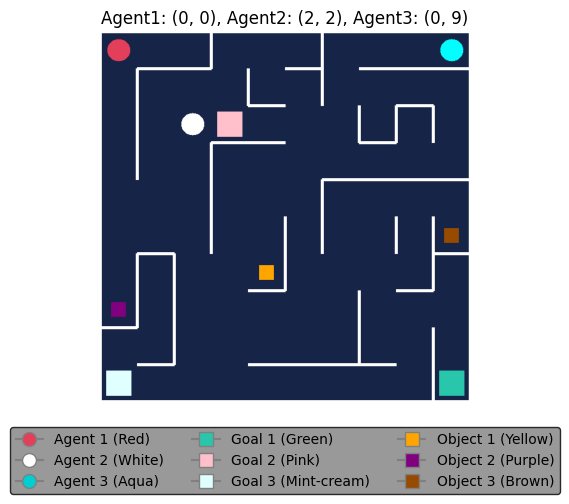

In [15]:
%matplotlib inline
env = Maze()
initial_state1 = env.reset1(0)
initial_state2 = env.reset2(0)
initial_state3 = env.reset3(0)
print(f"For Agent1 in red, goal1 in green, obj1 in yellow ")
print(f"For Agent2 in white, goal2 in pink, obj2 in purple ")
print(f"The new episode will start in state: {initial_state1}")
print(f"The new episode will start in state: {initial_state2}")
print(f"The new episode will start in state: {initial_state3}")

frame = env.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.title(f"Agent1: {initial_state1}, Agent2: {initial_state2}, Agent3: {initial_state3}")
agent1_patch = plt.Line2D([0], [0], marker='o', color = 'gray', markerfacecolor='#E43F5A', markersize=10, label="Agent 1 (Red)")
agent2_patch = plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='#FFFFFF', markersize=10, label="Agent 2 (White)")
agent3_patch = plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='#00CED1', markersize=10, label="Agent 3 (Aqua)")
goal1_patch = plt.Line2D([0], [0], marker='s', color='gray', markerfacecolor='#28C7AC', markersize=10, label="Goal 1 (Green)")
goal2_patch = plt.Line2D([0], [0], marker='s', color='gray', markerfacecolor='#FFC0CB', markersize=10, label="Goal 2 (Pink)")
goal3_patch = plt.Line2D([0], [0], marker='s', color='gray', markerfacecolor='#E0FFFF', markersize=10, label="Goal 3 (Mint-cream)")
obj1_patch = plt.Line2D([0], [0], marker='s', color='gray', markerfacecolor='#FFA500', markersize=10, label="Object 1 (Yellow)")
obj2_patch = plt.Line2D([0], [0], marker='s', color='gray', markerfacecolor='#800080', markersize=10, label="Object 2 (Purple)")
obj3_patch = plt.Line2D([0], [0], marker='s', color='gray', markerfacecolor='#964B00', markersize=10, label="Object 3 (Brown)")
plt.legend(handles=[agent1_patch, agent2_patch, agent3_patch,
                   goal1_patch, goal2_patch, goal3_patch,
                   obj1_patch, obj2_patch, obj3_patch],
          loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=10,
          frameon=True, facecolor="gray", edgecolor="black")
plt.show()

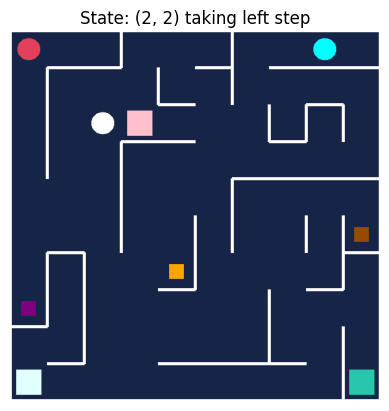

In [16]:
action = 3 # valid moves right = 1 or move down = 0
next_state, reward, done, info = env.step3(action)
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"State: {env.agent2} taking left step")
plt.imshow(frame)

# Working on training

## Action value table defining

In [17]:
# For agent1
AV_agent1_1 = np.zeros((10, 10, 4))
AV_agent1_2 = np.zeros((10, 10, 4))

# For Agent2
AV_agent2_1 = np.zeros((10, 10, 4))
AV_agent2_2 = np.zeros((10, 10, 4))

# For Agent3
AV_agent3_1 = np.zeros((10, 10, 4))
AV_agent3_2 = np.zeros((10, 10, 4))

## Defining policy

In [18]:
def target_policy(state: tuple, action_values: np.ndarray):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av == av.max()))

def exploratory_policy(state):
    return np.random.randint(4)

## Defining algorithm

In [19]:
def q_learning(AV_agent1_1, AV_agent1_2, AV_agent2_1, AV_agent2_2, AV_agent3_1, AV_agent3_2, exploratory_policy, target_policy,
               episodes, alpha=0.1, gamma=0.99):
  total_reward1 = 0
  total_reward2 = 0
  total_reward3 = 0
  total_reward_1 = 0
  total_reward_2 = 0
  total_reward_3 = 0

  # Store cumulative rewards
  rewards_per_episode1_1 = []
  rewards_per_episode1_2 = []
  rewards_per_episode2_1 = []
  rewards_per_episode2_2 = []
  rewards_per_episode3_1 = []
  rewards_per_episode3_2 = []

  # Store Q-value changes for convergence analysis
  q_value_diffs1_1 = []
  q_value_diffs1_2 = []
  q_value_diffs2_1 = []
  q_value_diffs2_2 = []
  q_value_diffs3_1 = []
  q_value_diffs3_2 = []

  # Average maximum Q-value
  avg_max_q_values1_1 = []
  avg_max_q_values1_2 = []
  avg_max_q_values2_1 = []
  avg_max_q_values2_2 = []
  avg_max_q_values3_1 = []
  avg_max_q_values3_2 = []

  for episode in range(1, episodes + 1):
      state1 = env.reset1(0)
      state2 = env.reset2(0)
      state3 = env.reset3(0)
      done1 = False
      done2 = False
      done3 = False
      prev_Q_1_1 = np.copy(AV_agent1_1)
      prev_Q_2_1 = np.copy(AV_agent2_1)
      prev_Q_3_1 = np.copy(AV_agent3_1)

      print(f"For Agent 1 Finding object1  at Episode:=> {episode}")
      while not done1:
          action = exploratory_policy(state1)
          next_state, reward, done1, _ = env.step1(action)
          next_action = target_policy(next_state, AV_agent1_1)
          total_reward1 += reward
          qsa = AV_agent1_1[state1][action]
          next_qsa = AV_agent1_1[next_state][next_action]
          AV_agent1_1[state1][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
          state1 = next_state
      rewards_per_episode1_1.append(total_reward1)
      q_value_diffs1_1.append(np.abs(AV_agent1_1 - prev_Q_1_1).sum())
      avg_max_q_values1_1.append(np.mean(np.max(AV_agent1_1, axis=2)))


      #for agent2 finding the obj
      print(f"For Agent 2 Finding object 2  at Episode:=> {episode}")
      while not done2:
          action = exploratory_policy(state2)
          next_state, reward, done2, _ = env.step2(action)
          next_action = target_policy(next_state, AV_agent2_1)
          total_reward2 += reward
          qsa2 = AV_agent2_1[state2][action]
          next_qsa2 = AV_agent2_1[next_state][next_action]
          AV_agent2_1[state2][action] = qsa2 + alpha * (reward + gamma * next_qsa2 - qsa2)
          state2 = next_state

      rewards_per_episode2_1.append(total_reward2)
      q_value_diffs2_1.append(np.abs(AV_agent2_1 - prev_Q_2_1).sum())
      avg_max_q_values2_1.append(np.mean(np.max(AV_agent2_1, axis=2)))

      #for agent3 finding the obj
      print(f"For Agent 3 Finding object 3  at Episode:=> {episode}")
      while not done3:
          action = exploratory_policy(state3)
          next_state, reward, done3, _ = env.step3(action)
          next_action = target_policy(next_state, AV_agent3_1)
          total_reward3 += reward
          qsa3 = AV_agent3_1[state3][action]
          next_qsa3 = AV_agent3_1[next_state][next_action]
          AV_agent3_1[state3][action] = qsa3 + alpha * (reward + gamma * next_qsa3 - qsa3)
          state3 = next_state

      rewards_per_episode3_1.append(total_reward3)
      q_value_diffs3_1.append(np.abs(AV_agent3_1 - prev_Q_3_1).sum())
      avg_max_q_values3_1.append(np.mean(np.max(AV_agent3_1, axis=2)))

  print(f" FInding goals")

# Finding the goal
  for episode in range(1, episodes + 1):
        state1 = env.reset1(1)
        state2 = env.reset2(1)
        state3 = env.reset3(1)
        done1 = False
        done2 = False
        done3 = False
        prev_Q_1_2 = np.copy(AV_agent1_2)
        prev_Q_2_2 = np.copy(AV_agent2_2)
        prev_Q_3_2 = np.copy(AV_agent3_2)

        print(f"For Agent 1 Finding Goal 1  at Episode:=> {episode}")
        while not done1:
            action = exploratory_policy(state1)
            # print(f"action goal {episode} is : {action}")
            next_state, reward, done1, _ = env.step1(action)
            # print(f"Action for the reward, Next_state, next_state:{next_state},reward:{reward}, done:{done1}  ")
            next_action = target_policy(next_state, AV_agent1_2)
            # print(f"next_action: {next_action}")
            total_reward_1 += reward
            qsa = AV_agent1_2[state1][action]
            # print(f"qsa Vaalue :{qsa}")
            next_qsa = AV_agent1_2[next_state][next_action]
            # print(f"next_qsa Vaalue :{next_qsa}")
            AV_agent1_2[state1][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state1 = next_state

        rewards_per_episode1_2.append(total_reward_1)
        q_value_diffs1_2.append(np.abs(AV_agent1_2 - prev_Q_1_2).sum())
        avg_max_q_values1_2.append(np.mean(np.max(AV_agent1_2, axis=2)))

        print(f"For Agent 2 Finding Goal 2  at Episode:=> {episode}")
        while not done2:
            action = exploratory_policy(state2)
            # print(f"action goal {episode} is : {action}")
            next_state, reward, done2, _ = env.step2(action)
            # print(f"Action for episode {episode} the reward, Next_state, next_state:{next_state},reward:{reward}, done:{done2}")
            next_action = target_policy(next_state, AV_agent2_2)
            # print(f"next_action: {next_action}")
            total_reward_2 += reward
            qsa2 = AV_agent2_2[state2][action]
            # print(f"qsa Value :{qsa2}")
            next_qsa2 = AV_agent2_2[next_state][next_action]
            # print(f"next_qsa Value :{next_qsa2}")
            AV_agent2_2[state2][action] = qsa2 + alpha * (reward + gamma * next_qsa2 - qsa2)
            state2 = next_state

        rewards_per_episode2_2.append(total_reward_2)
        q_value_diffs2_2.append(np.abs(AV_agent2_2 - prev_Q_2_2).sum())
        avg_max_q_values2_2.append(np.mean(np.max(AV_agent2_2, axis=2)))


        #for agent3 finding the goal
        print(f"For Agent 3 Finding Goal 3  at Episode:=> {episode}")
        while not done3:
            action = exploratory_policy(state3)
            # print(f"action goal {episode} is : {action}")
            next_state, reward, done3, _ = env.step3(action)
            # print(f"Action for episode {episode} the reward, Next_state, next_state:{next_state},reward:{reward}, done:{done3}")
            next_action = target_policy(next_state, AV_agent3_2)
            # print(f"next_action: {next_action}")
            total_reward_3 += reward
            qsa3 = AV_agent3_2[state3][action]
            # print(f"qsa Value :{qsa2}")
            next_qsa3 = AV_agent3_2[next_state][next_action]
            # print(f"next_qsa Value :{next_qsa2}")
            AV_agent3_2[state3][action] = qsa3 + alpha * (reward + gamma * next_qsa3 - qsa3)
            state3 = next_state

        rewards_per_episode3_2.append(total_reward_3)
        q_value_diffs3_2.append(np.abs(AV_agent3_2 - prev_Q_3_2).sum())
        avg_max_q_values3_2.append(np.mean(np.max(AV_agent3_2, axis=2)))

  return   rewards_per_episode1_1, rewards_per_episode1_2, rewards_per_episode2_1, rewards_per_episode2_2 , rewards_per_episode3_1, rewards_per_episode3_2,q_value_diffs1_1, q_value_diffs1_2, q_value_diffs2_1, q_value_diffs2_2, q_value_diffs3_1, q_value_diffs3_2,   avg_max_q_values1_1, avg_max_q_values1_2, avg_max_q_values2_1, avg_max_q_values2_2, avg_max_q_values3_1 , avg_max_q_values3_2

## Running Algorithm

In [20]:
rewards_per_episode1_1, rewards_per_episode1_2, rewards_per_episode2_1, rewards_per_episode2_2 , rewards_per_episode3_1, rewards_per_episode3_2, q_value_diffs1_1, q_value_diffs1_2, q_value_diffs2_1, q_value_diffs2_2, q_value_diffs3_1, q_value_diffs3_2, avg_max_q_values1_1, avg_max_q_values1_2, avg_max_q_values2_1, avg_max_q_values2_2, avg_max_q_values3_1 , avg_max_q_values3_2 = q_learning(AV_agent1_1, AV_agent1_2, AV_agent2_1, AV_agent2_2, AV_agent3_1, AV_agent3_2, exploratory_policy, target_policy, 10000)

Streaming output truncated to the last 5000 lines.
For Agent 2 Finding Goal 2  at Episode:=> 8334
For Agent 3 Finding Goal 3  at Episode:=> 8334
For Agent 1 Finding Goal 1  at Episode:=> 8335
For Agent 2 Finding Goal 2  at Episode:=> 8335
For Agent 3 Finding Goal 3  at Episode:=> 8335
For Agent 1 Finding Goal 1  at Episode:=> 8336
For Agent 2 Finding Goal 2  at Episode:=> 8336
For Agent 3 Finding Goal 3  at Episode:=> 8336
For Agent 1 Finding Goal 1  at Episode:=> 8337
For Agent 2 Finding Goal 2  at Episode:=> 8337
For Agent 3 Finding Goal 3  at Episode:=> 8337
For Agent 1 Finding Goal 1  at Episode:=> 8338
For Agent 2 Finding Goal 2  at Episode:=> 8338
For Agent 3 Finding Goal 3  at Episode:=> 8338
For Agent 1 Finding Goal 1  at Episode:=> 8339
For Agent 2 Finding Goal 2  at Episode:=> 8339
For Agent 3 Finding Goal 3  at Episode:=> 8339
For Agent 1 Finding Goal 1  at Episode:=> 8340
For Agent 2 Finding Goal 2  at Episode:=> 8340
For Agent 3 Finding Goal 3  at Episode:=> 8340
For Agent

# Visualization After Training

## Visualization in plot

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(episodes, rewards, q_value_diffs, avg_max_q_values, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title, fontsize=14, fontweight='bold')

    # Plot rewards
    plt.subplot(1, 3, 1)
    plt.plot(range(1, episodes + 1), rewards, label='Total Reward', color='blue')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.legend()

    # Plot Q-value differences
    plt.subplot(1, 3, 2)
    plt.plot(range(1, episodes + 1), q_value_diffs, label='Q-Value Difference', color='red')
    plt.xlabel('Episodes')
    plt.ylabel('Q-Value Difference')
    plt.title('Q-Value Convergence')
    plt.legend()

    # Plot average max Q-values
    plt.subplot(1, 3, 3)
    plt.plot(range(1, episodes + 1), avg_max_q_values, label='Avg Max Q-Value', color='green')
    plt.xlabel('Episodes')
    plt.ylabel('Avg Max Q-Value')
    plt.title('Average Max Q-Value')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

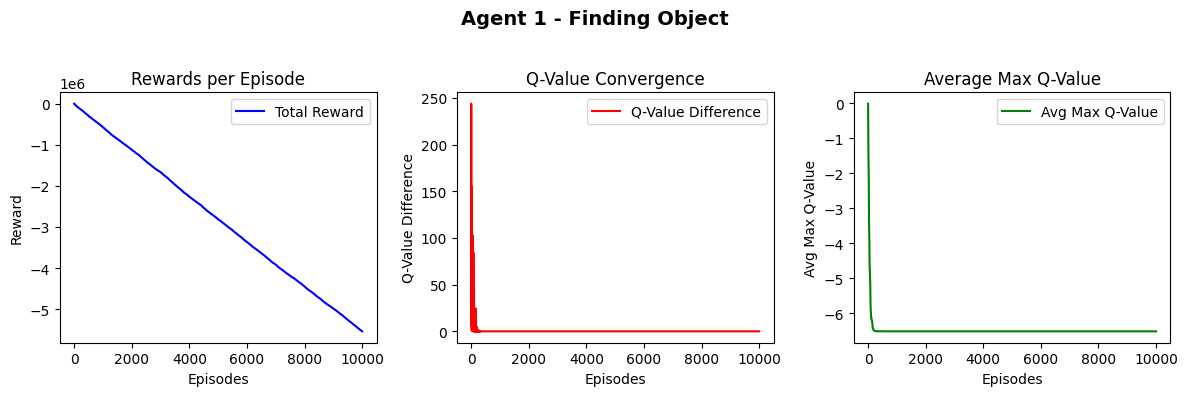

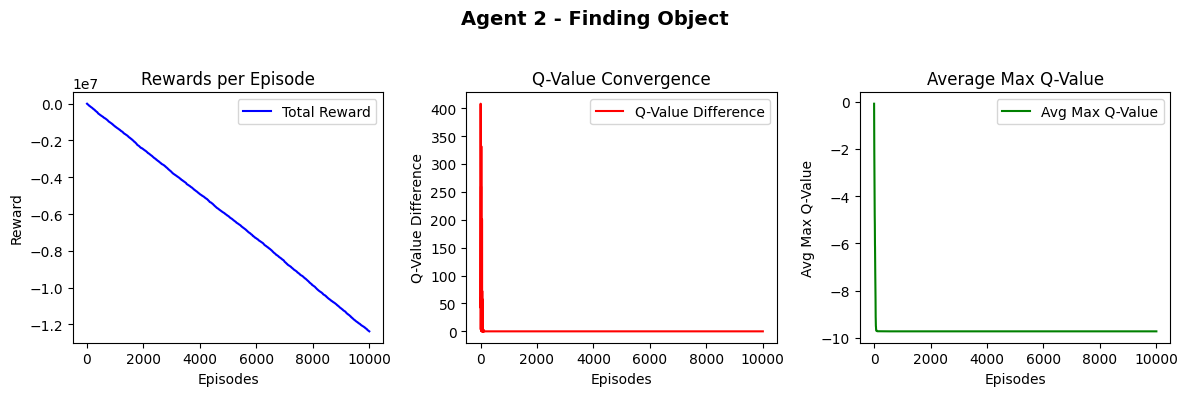

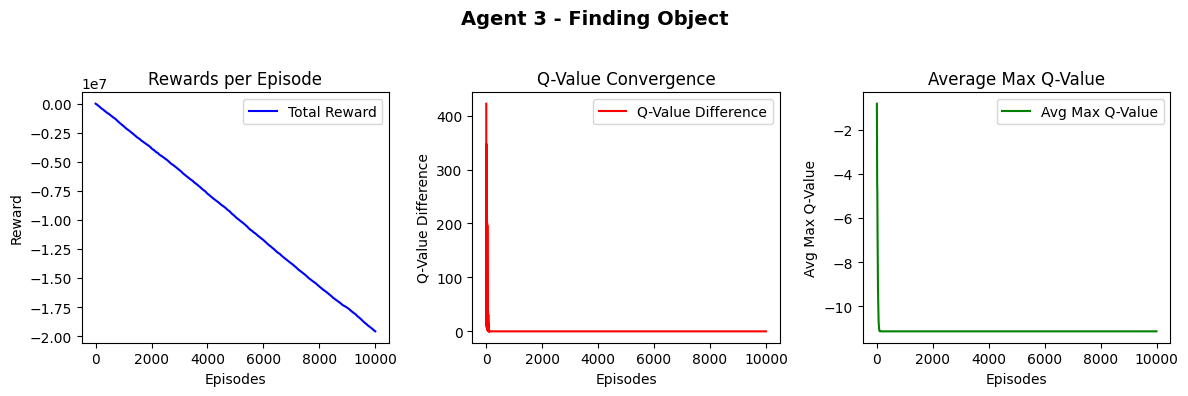

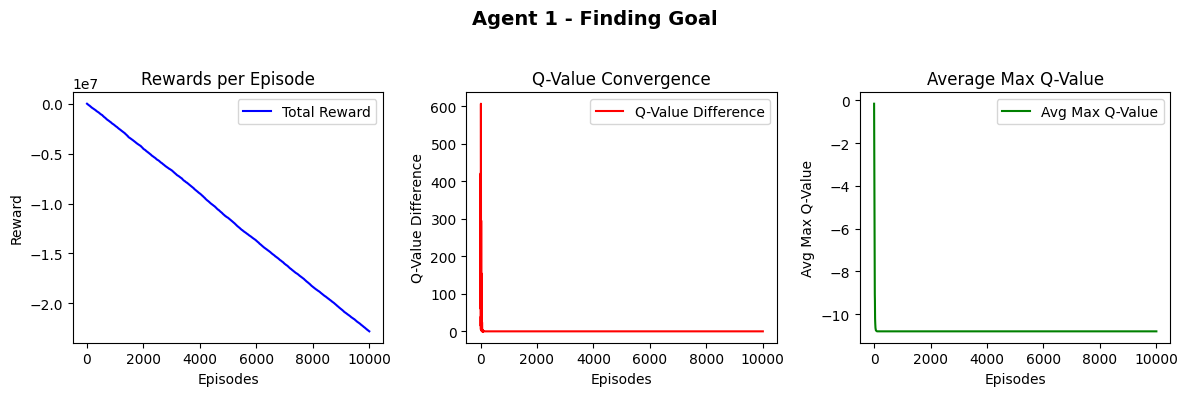

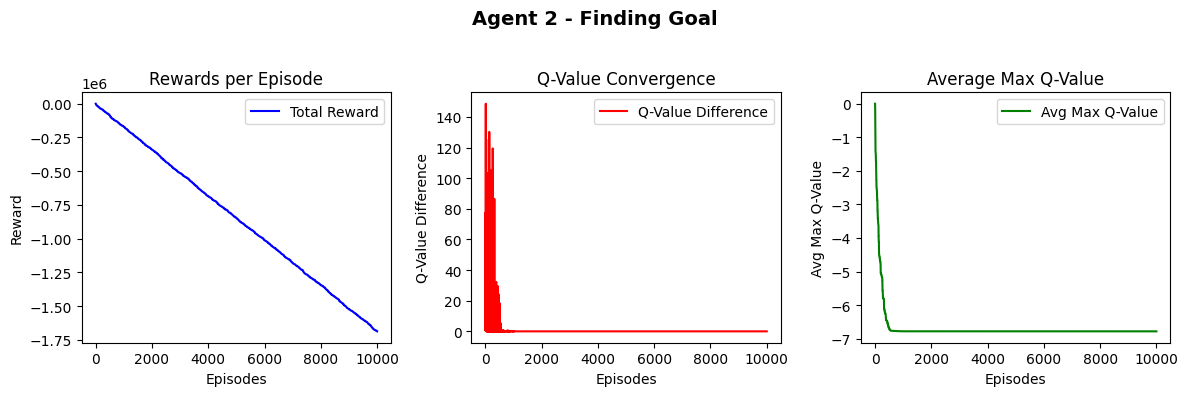

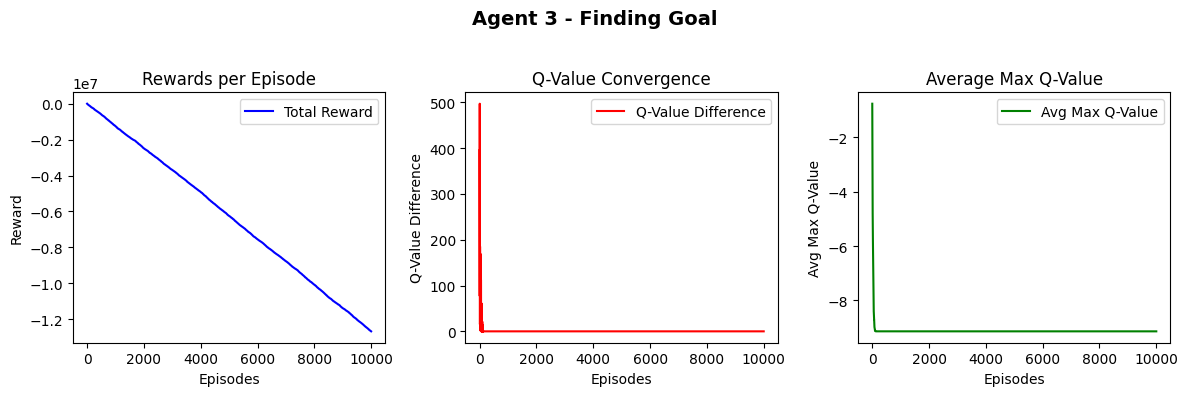

In [22]:
# Plot for each agent
plot_metrics(len(rewards_per_episode1_1), rewards_per_episode1_1, q_value_diffs1_1, avg_max_q_values1_1, "Agent 1 - Finding Object")
plot_metrics(len(rewards_per_episode2_1), rewards_per_episode2_1, q_value_diffs2_1, avg_max_q_values2_1, "Agent 2 - Finding Object")
plot_metrics(len(rewards_per_episode3_1), rewards_per_episode3_1, q_value_diffs3_1, avg_max_q_values3_1, "Agent 3 - Finding Object")

plot_metrics(len(rewards_per_episode1_2), rewards_per_episode1_2, q_value_diffs1_2, avg_max_q_values1_2, "Agent 1 - Finding Goal")
plot_metrics(len(rewards_per_episode2_2), rewards_per_episode2_2, q_value_diffs2_2, avg_max_q_values2_2, "Agent 2 - Finding Goal")
plot_metrics(len(rewards_per_episode3_2), rewards_per_episode3_2, q_value_diffs3_2, avg_max_q_values3_2, "Agent 3 - Finding Goal")


## Visualization of each agent for specified episodes

### Agent 1

In [23]:
# For Object identification
first_200_rewards1_1 = rewards_per_episode1_1[:200]
first_200_q_value_diffs1_1 = q_value_diffs1_1[:200]
first_200_avg_max_q_values1_1 = avg_max_q_values1_1[:200]

# For goal identification
first_200_rewards1_2 = rewards_per_episode1_2[:200]
first_200_q_value_diffs1_2 = q_value_diffs1_2[:200]
first_200_avg_max_q_values1_2 = avg_max_q_values1_2[:200]

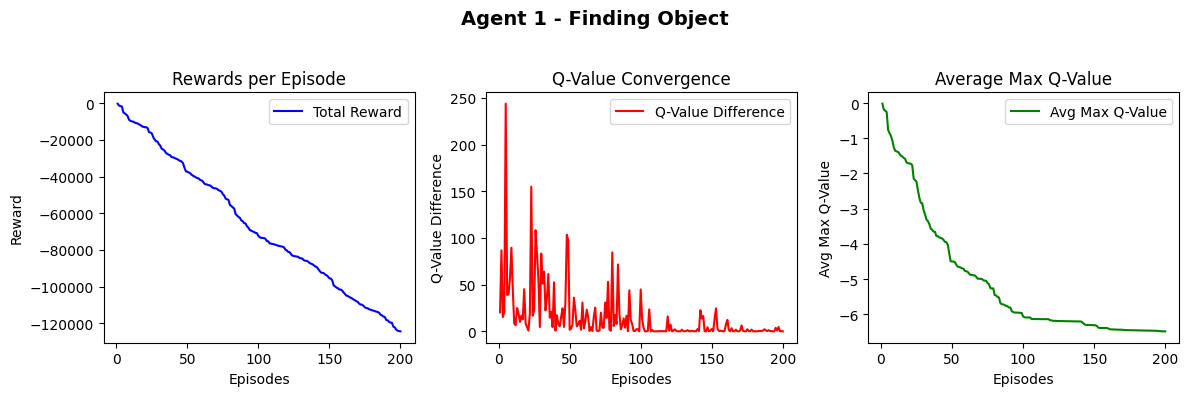

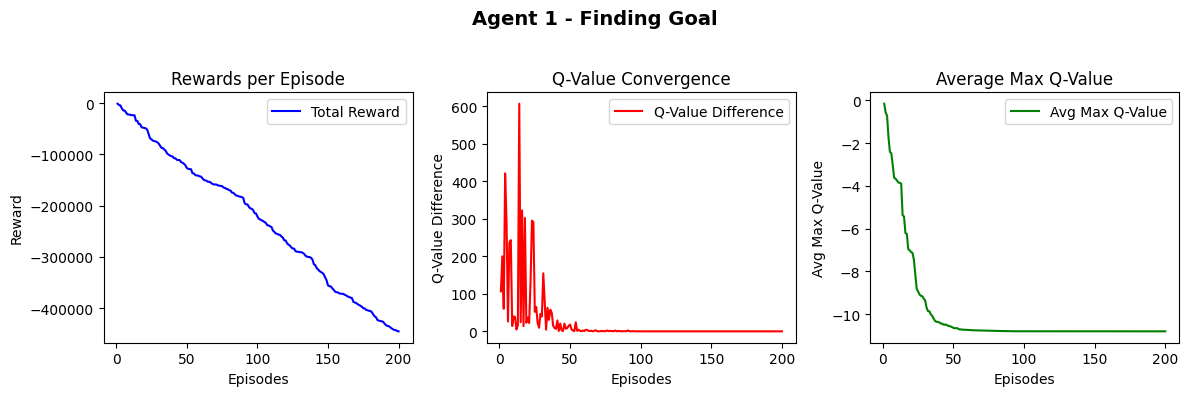

In [24]:
# Plot
plot_metrics(len(first_200_rewards1_1), first_200_rewards1_1, first_200_q_value_diffs1_1, first_200_avg_max_q_values1_1, "Agent 1 - Finding Object")
plot_metrics(len(first_200_rewards1_2), first_200_rewards1_2, first_200_q_value_diffs1_2, first_200_avg_max_q_values1_2, "Agent 1 - Finding Goal")

### Agent 2

In [25]:
# For Object identification
first_200_rewards2_1 = rewards_per_episode2_1[:200]
first_200_q_value_diffs2_1 = q_value_diffs2_1[:200]
first_200_avg_max_q_values2_1 = avg_max_q_values2_1[:200]

# For goal identification
first_200_rewards2_2 = rewards_per_episode2_2[:200]
first_200_q_value_diffs2_2 = q_value_diffs2_2[:200]
first_200_avg_max_q_values2_2 = avg_max_q_values2_2[:200]

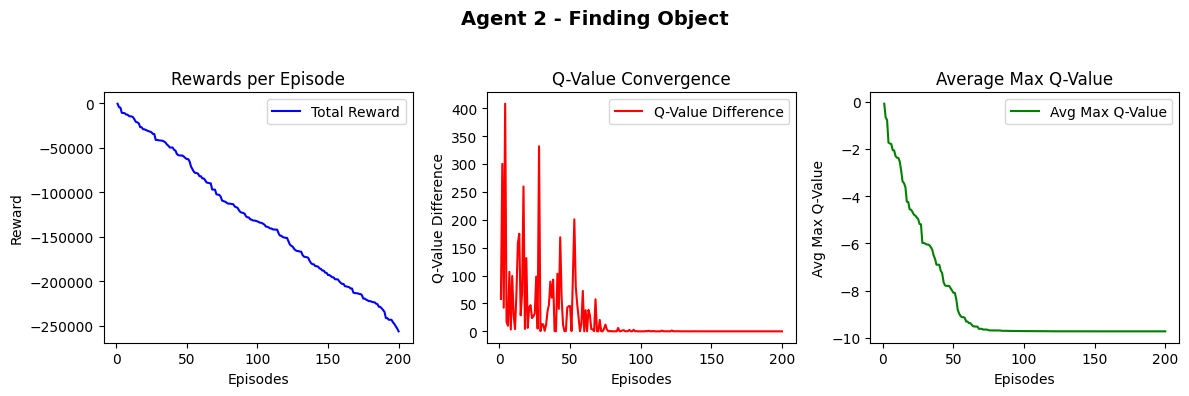

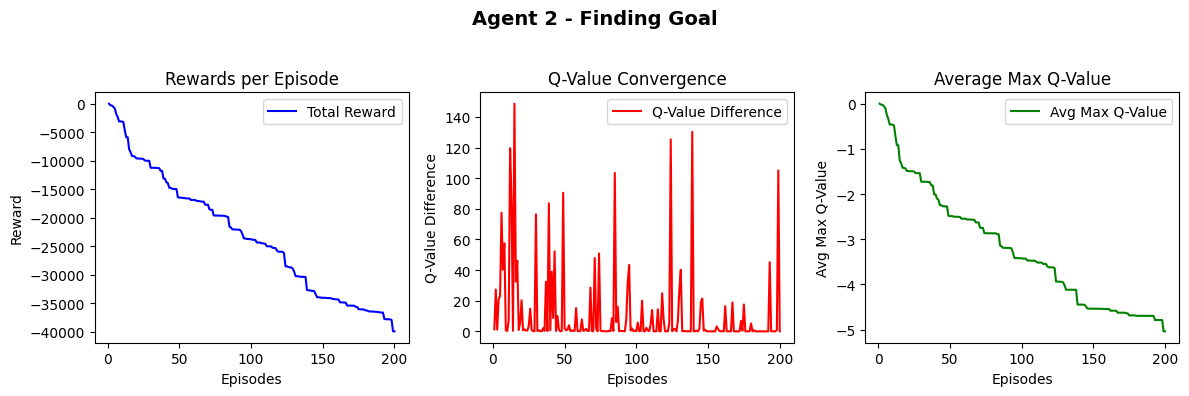

In [26]:
# Plot
plot_metrics(len(first_200_rewards2_1), first_200_rewards2_1, first_200_q_value_diffs2_1, first_200_avg_max_q_values2_1, "Agent 2 - Finding Object")
plot_metrics(len(first_200_rewards2_2), first_200_rewards2_2, first_200_q_value_diffs2_2, first_200_avg_max_q_values2_2, "Agent 2 - Finding Goal")

### Agent 3

In [27]:
# For Object identification
first_200_rewards3_1 = rewards_per_episode3_1[:200]
first_200_q_value_diffs3_1 = q_value_diffs3_1[:200]
first_200_avg_max_q_values3_1 = avg_max_q_values3_1[:200]

# For goal identification
first_200_rewards3_2 = rewards_per_episode3_2[:200]
first_200_q_value_diffs3_2 = q_value_diffs3_2[:200]
first_200_avg_max_q_values3_2 = avg_max_q_values3_2[:200]

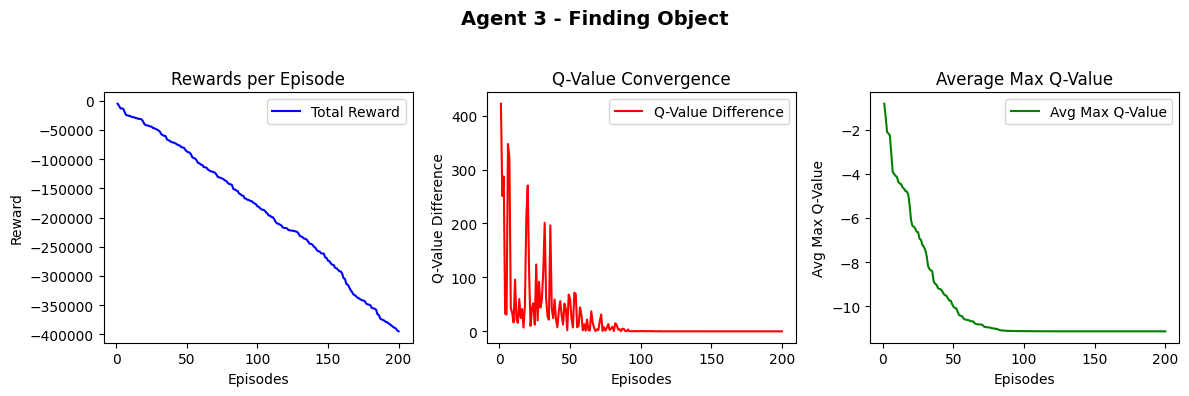

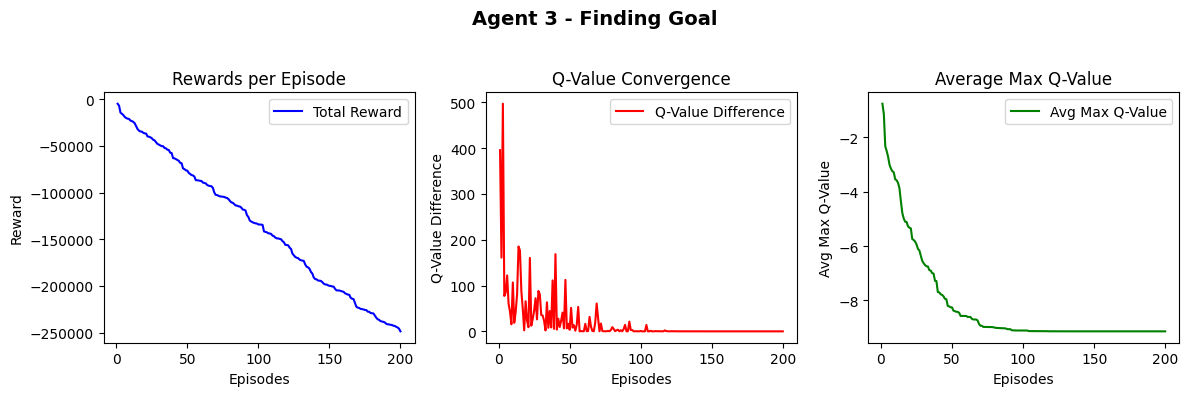

In [28]:
# Plot
plot_metrics(len(first_200_rewards3_1), first_200_rewards3_1, first_200_q_value_diffs3_1, first_200_avg_max_q_values3_1, "Agent 3 - Finding Object")
plot_metrics(len(first_200_rewards3_2), first_200_rewards3_2, first_200_q_value_diffs3_2, first_200_avg_max_q_values3_2, "Agent 3 - Finding Goal")

## Action value plot and Policy plot

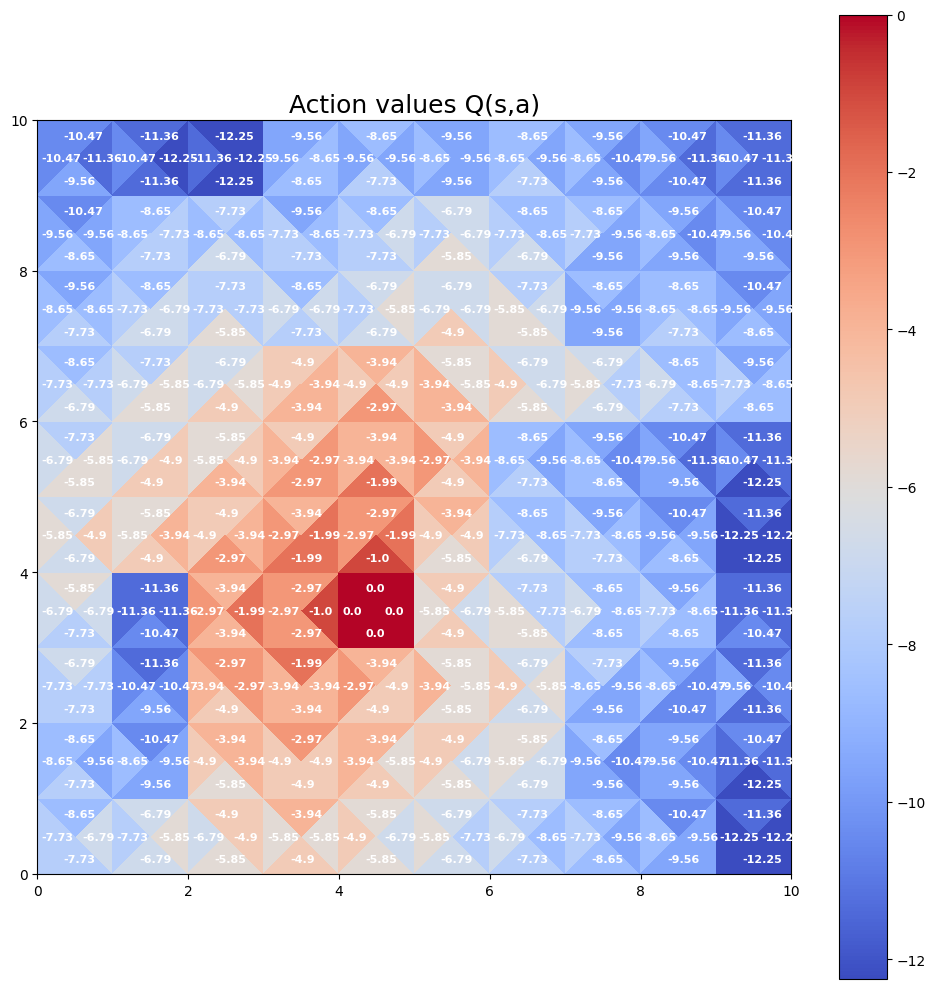

(None, None)

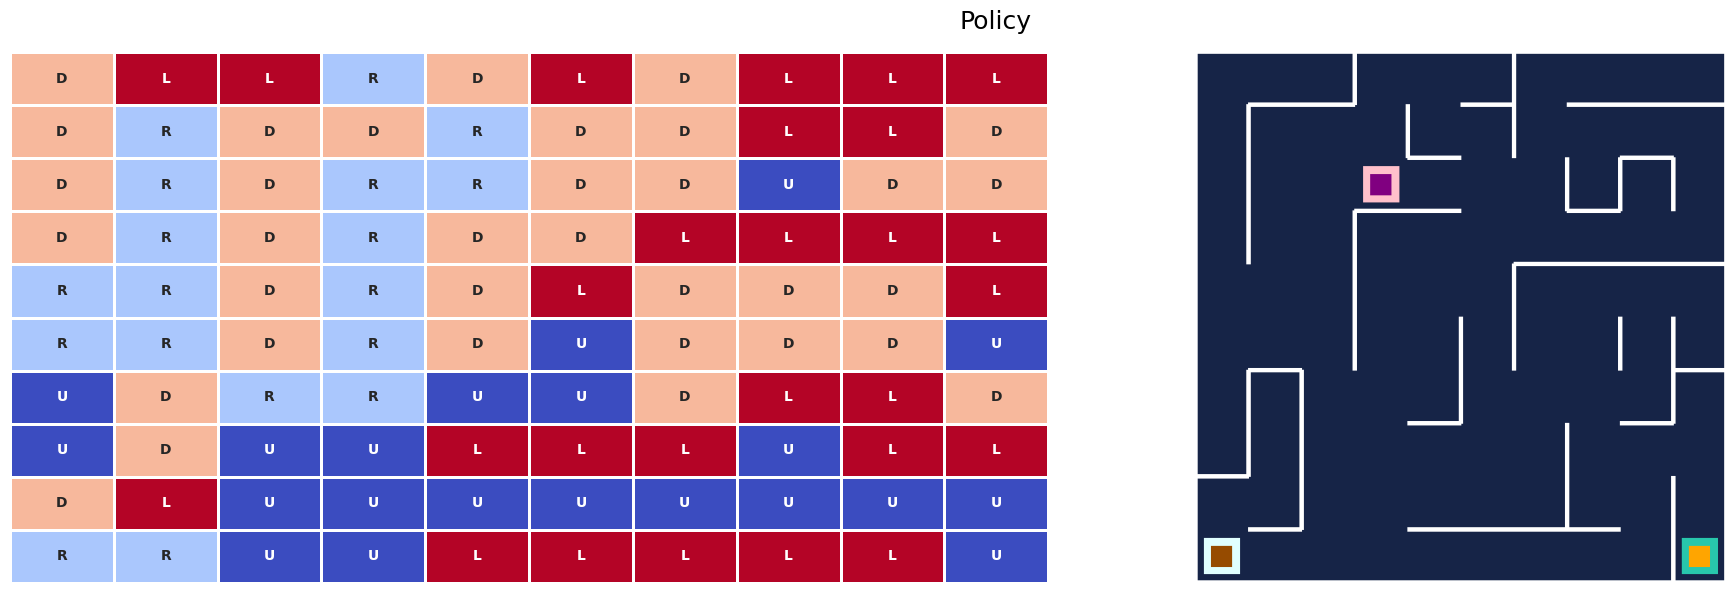

In [29]:
plot_action_values(AV_agent1_1), plot_policy(AV_agent1_1, env.render(mode='rgb_array'))

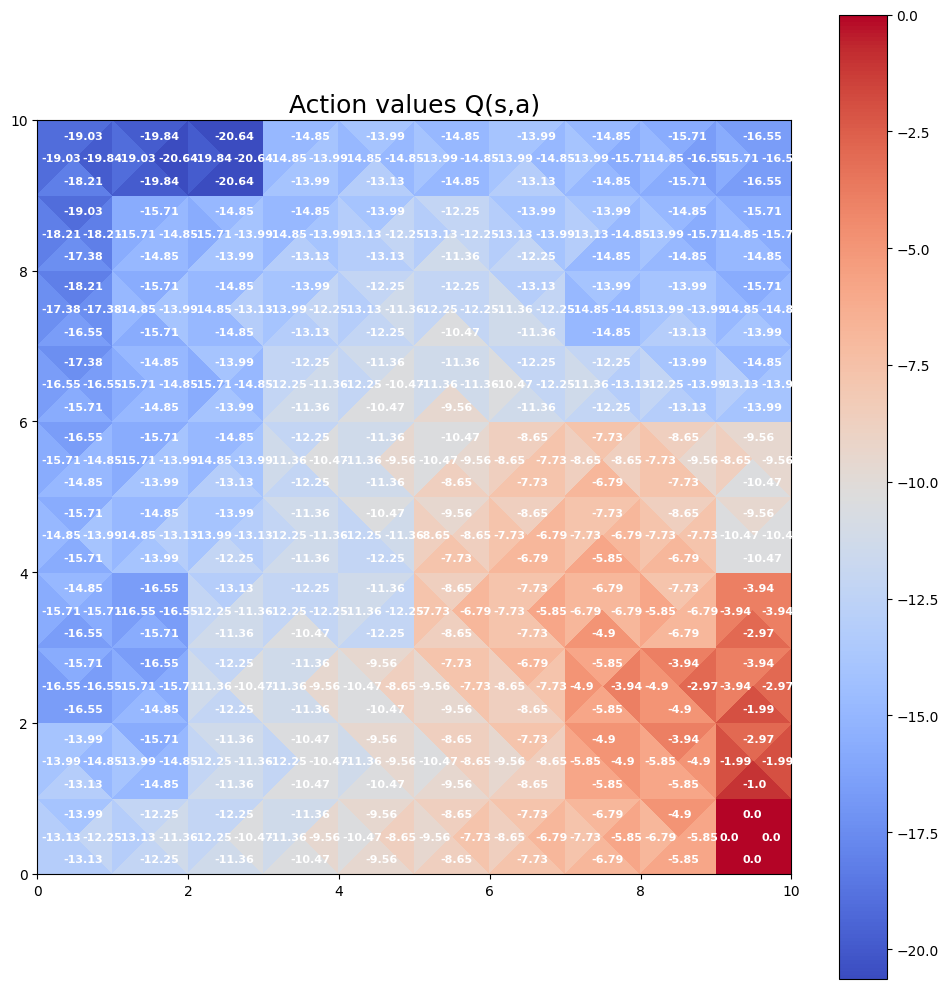

(None, None)

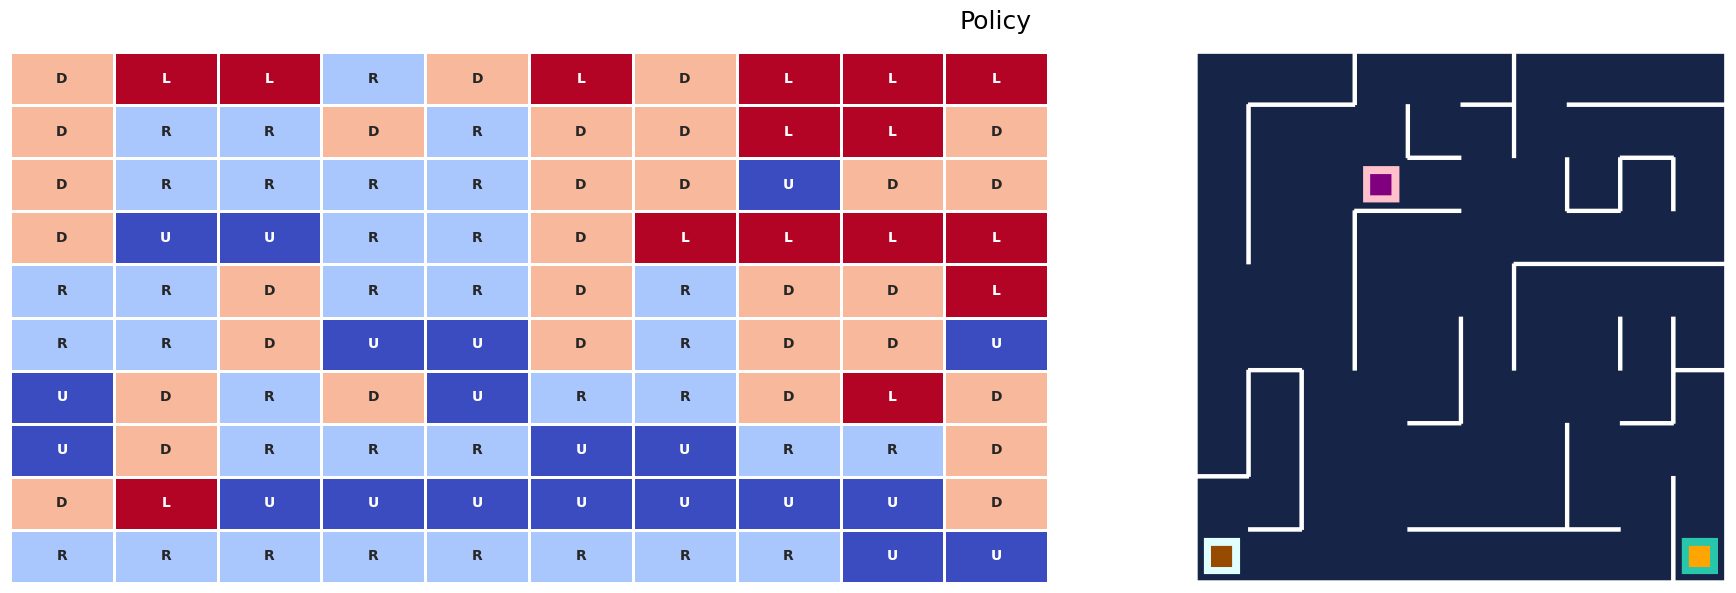

In [30]:
plot_action_values(AV_agent1_2), plot_policy(AV_agent1_2, env.render(mode='rgb_array'))

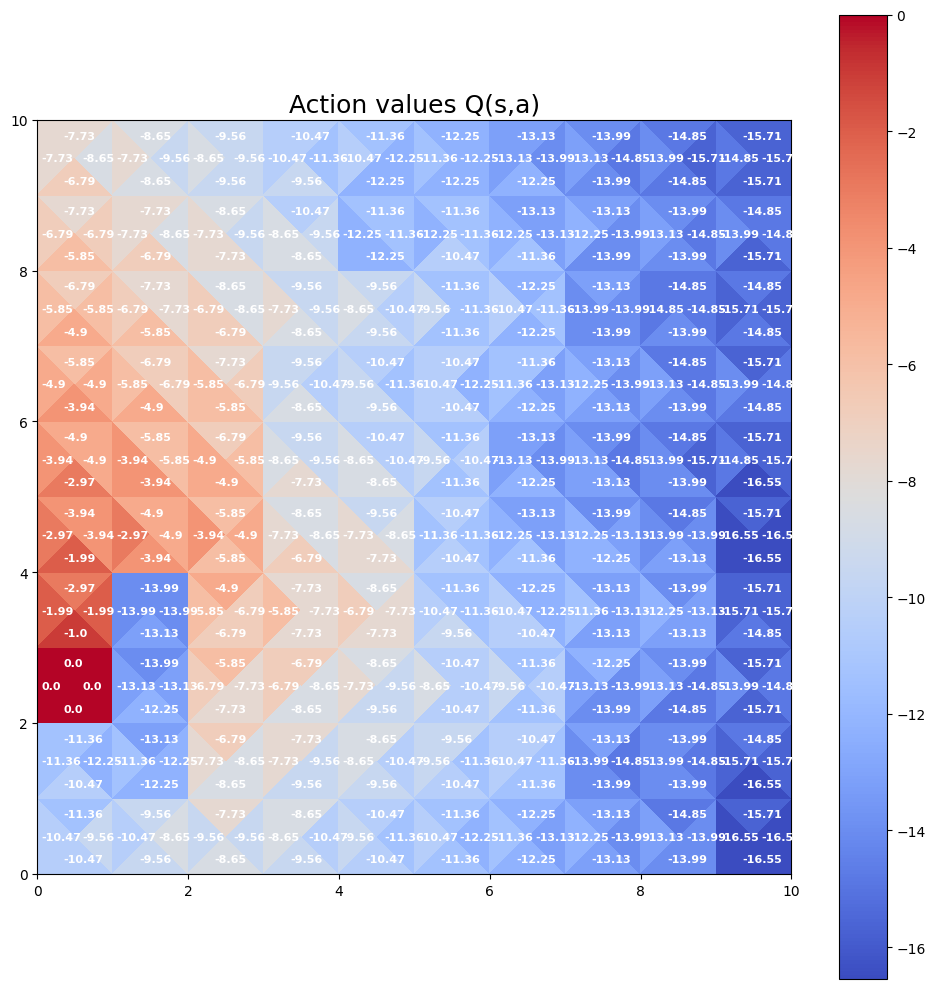

(None, None)

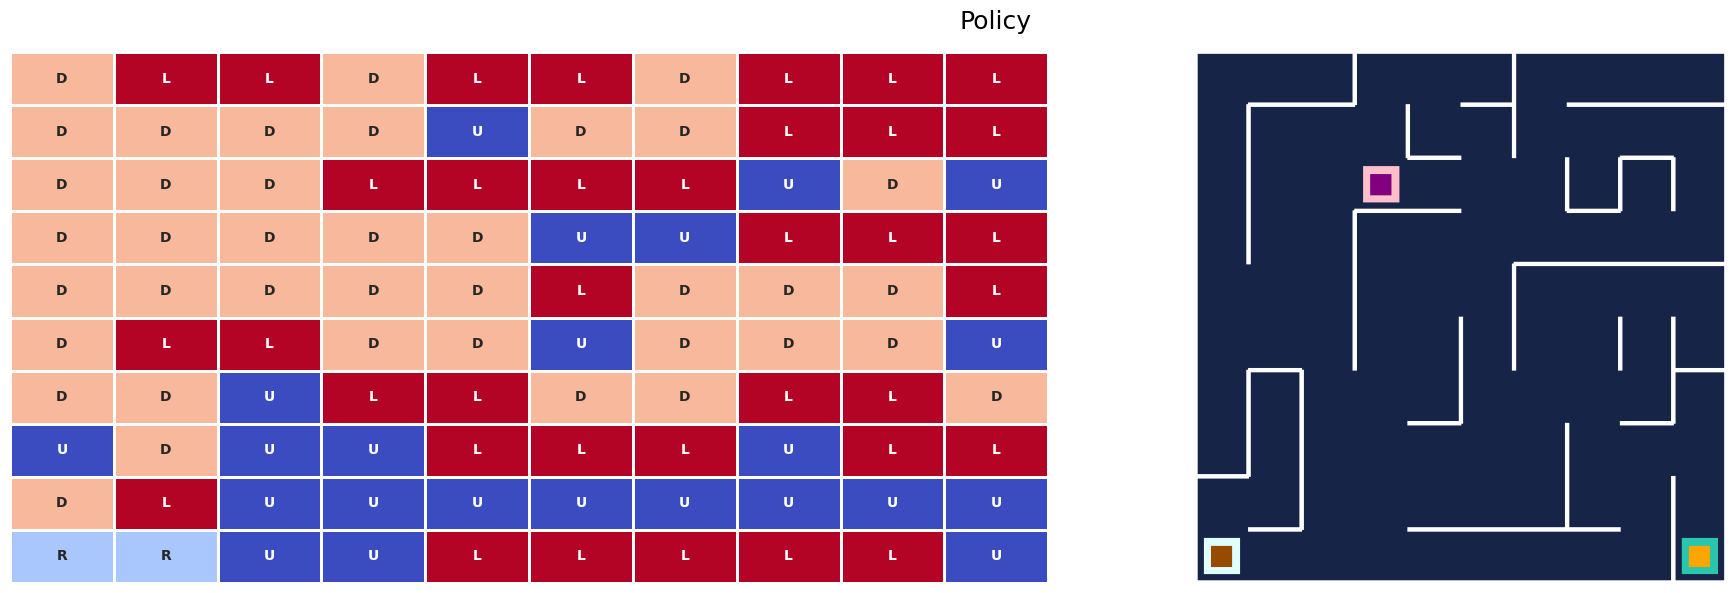

In [31]:
plot_action_values(AV_agent2_1), plot_policy(AV_agent2_1, env.render(mode='rgb_array'))

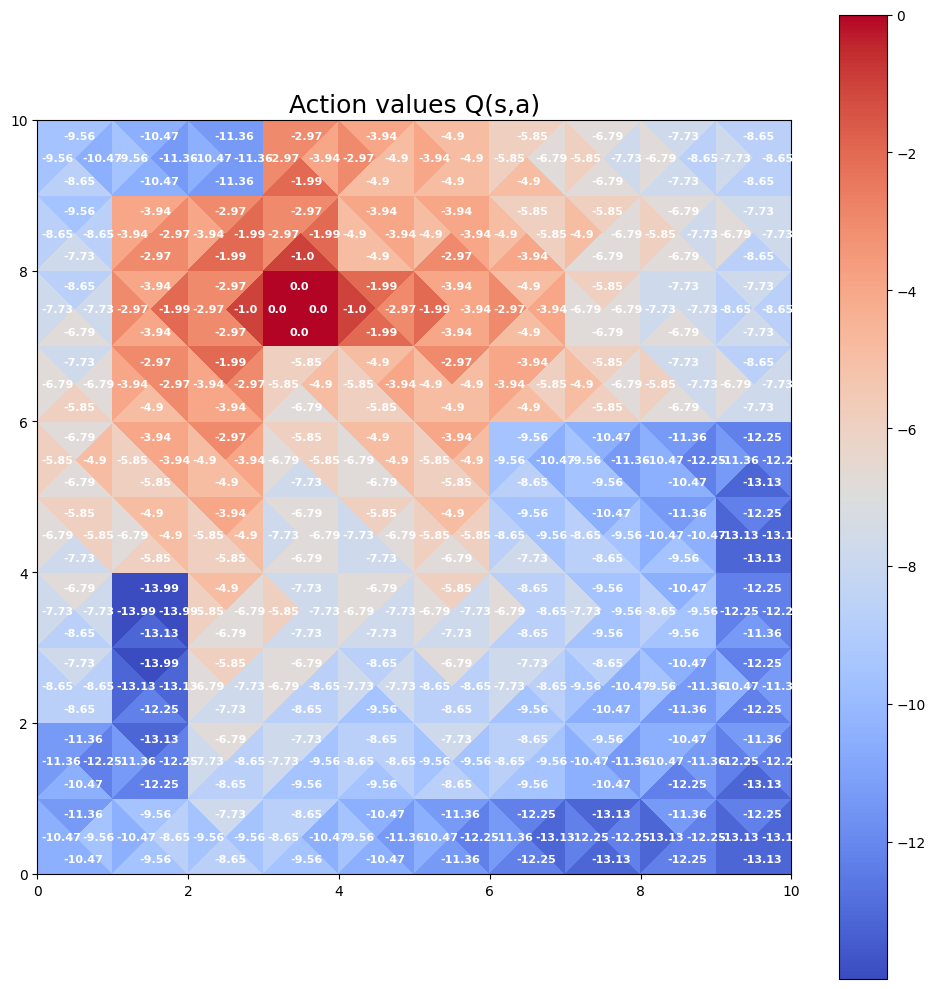

(None, None)

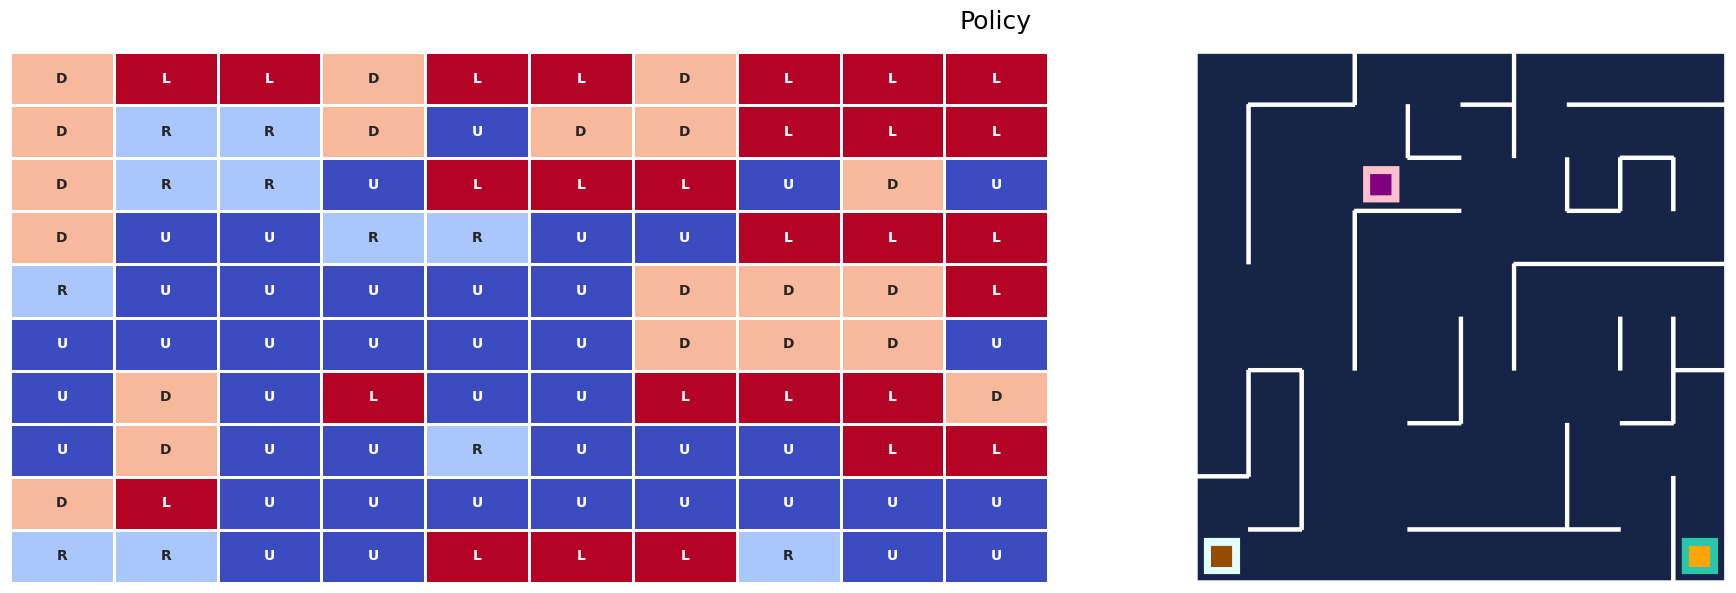

In [32]:
plot_action_values(AV_agent2_2), plot_policy(AV_agent2_2, env.render(mode='rgb_array'))

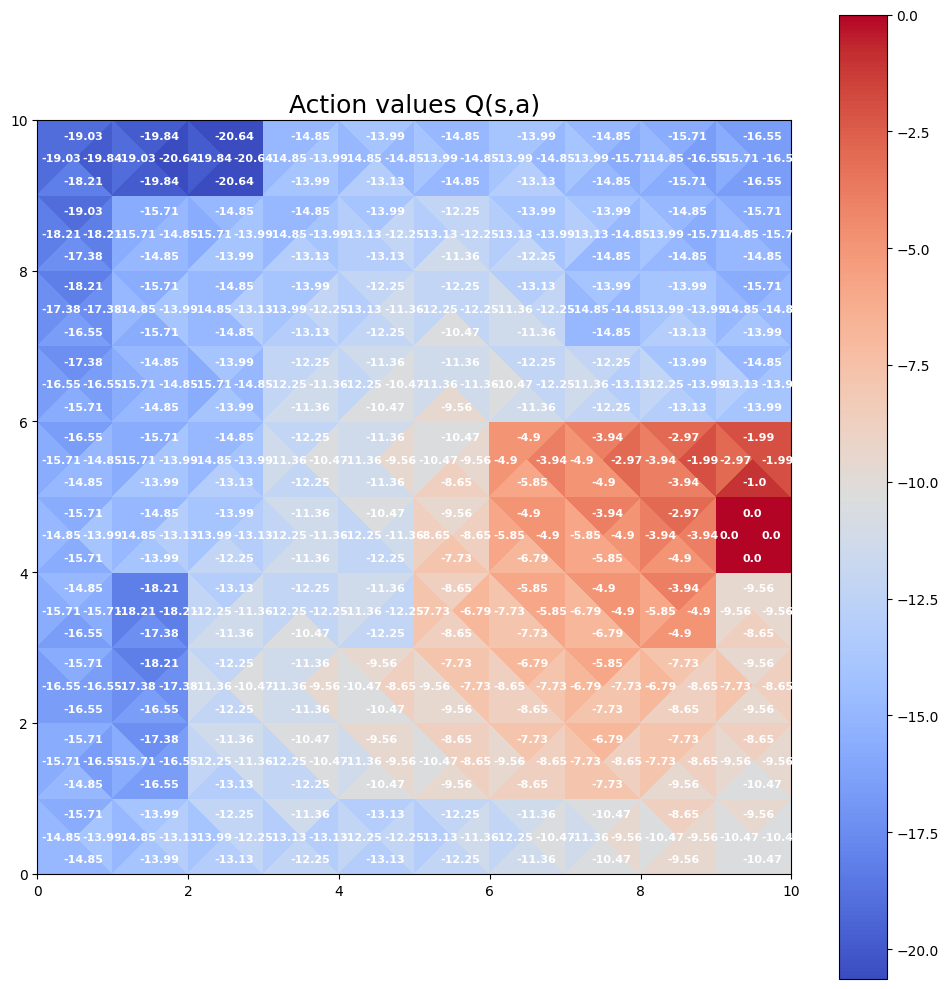

(None, None)

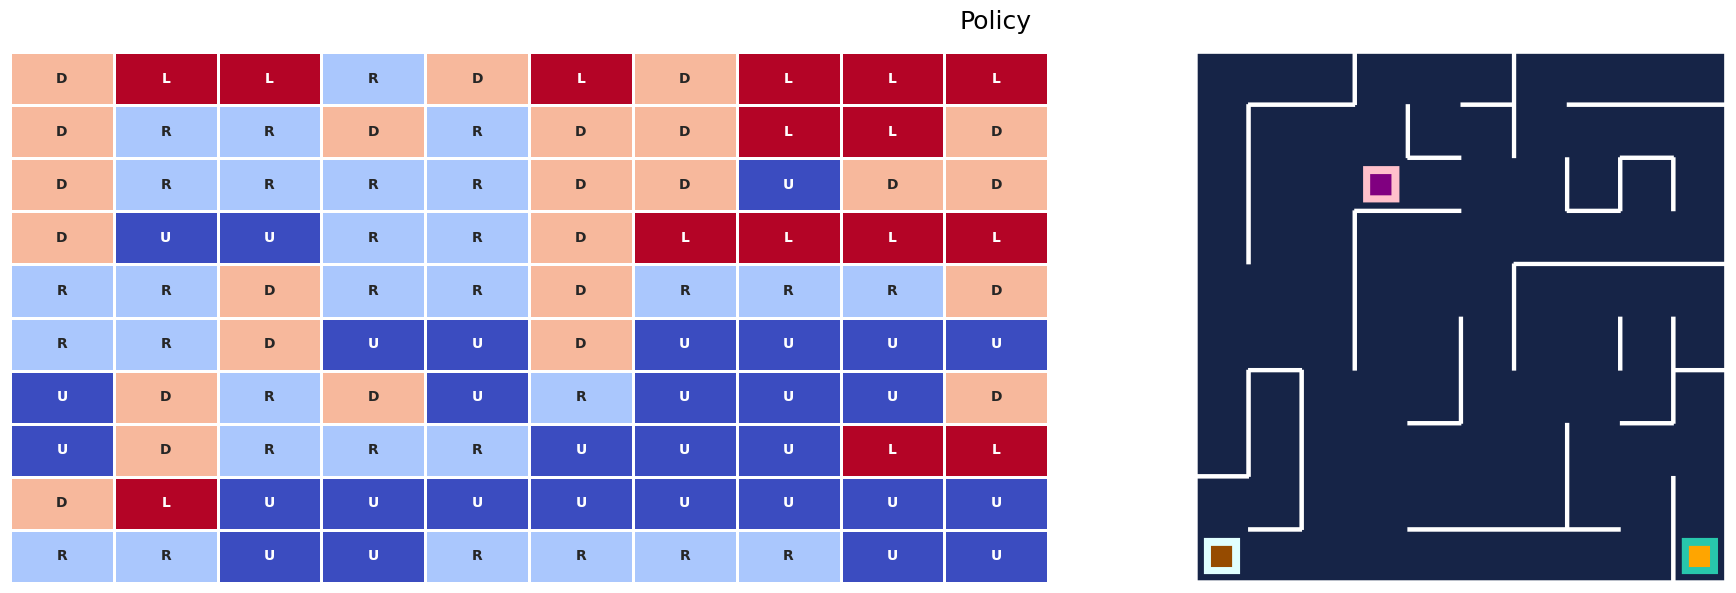

In [33]:
plot_action_values(AV_agent3_1), plot_policy(AV_agent3_1, env.render(mode='rgb_array'))

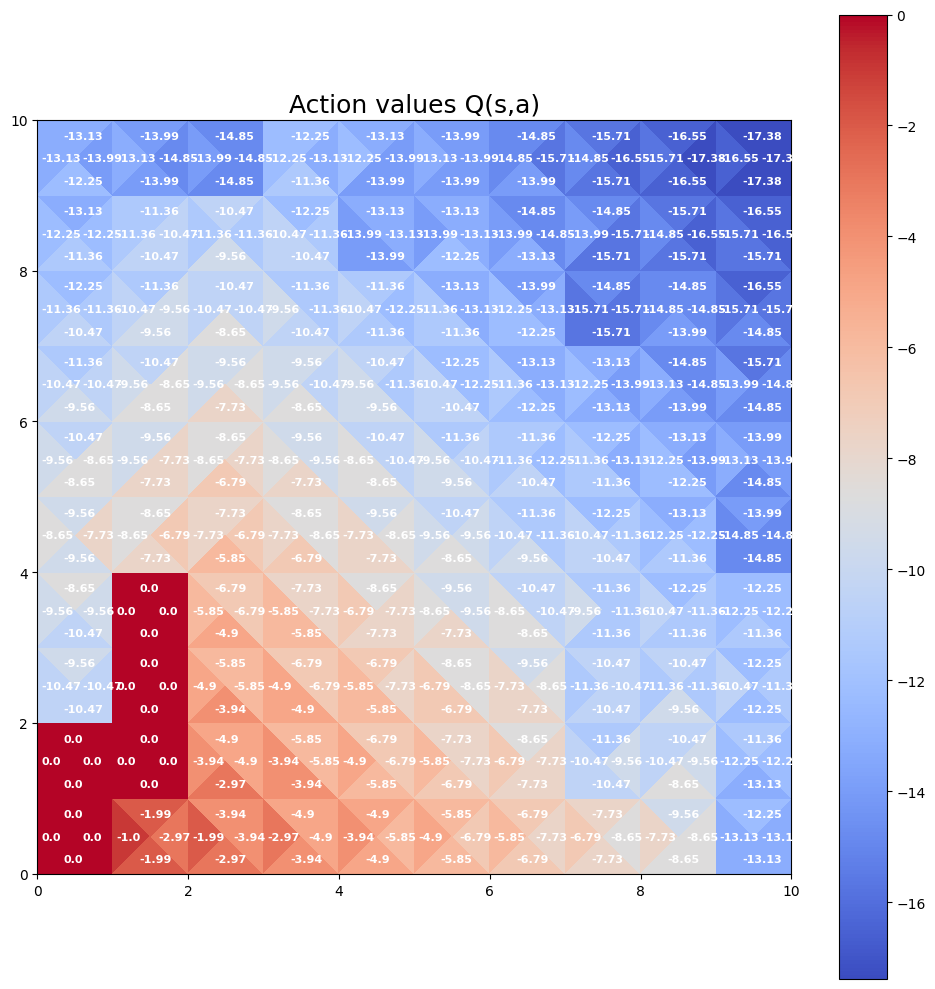

(None, None)

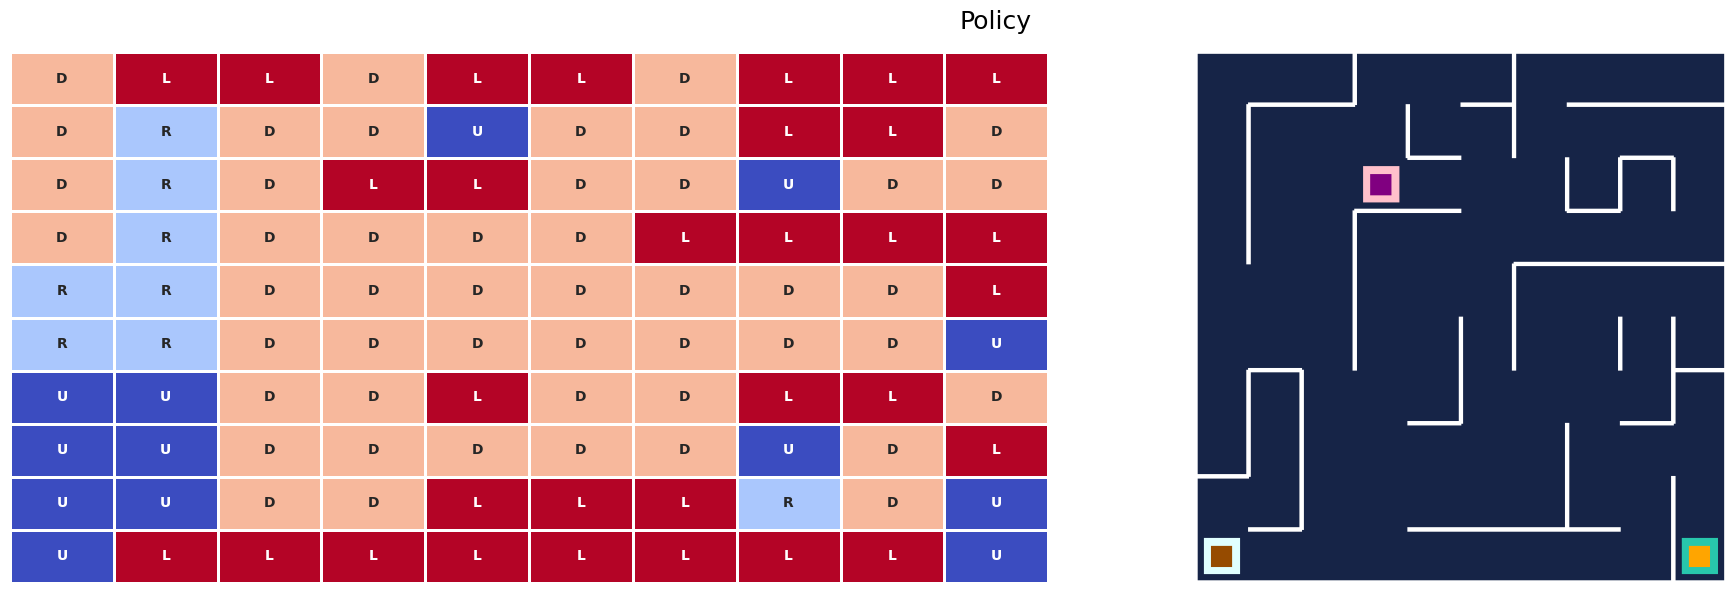

In [34]:
plot_action_values(AV_agent3_2),plot_policy(AV_agent3_2, env.render(mode='rgb_array'))

# Save an action value table

In [36]:
# Agent 1 save
agent1_O_reshaped = AV_agent1_1.reshape(AV_agent1_1.shape[0], -1)
np.savetxt('/content/drive/MyDrive/RL Project/Final defence code/agent1_O_reshaped.csv', agent1_O_reshaped, delimiter=',')

agent1_G_reshaped = AV_agent1_2.reshape(AV_agent1_2.shape[0], -1)
np.savetxt('/content/drive/MyDrive/RL Project/Final defence code/agent1_G_reshaped.csv', agent1_G_reshaped, delimiter=',')

# Agent 2 save
agent2_O_reshaped = AV_agent2_1.reshape(AV_agent2_1.shape[0], -1)
np.savetxt('/content/drive/MyDrive/RL Project/Final defence code/agent2_O_reshaped.csv', agent2_O_reshaped, delimiter=',')

agent2_G_reshaped = AV_agent2_2.reshape(AV_agent2_2.shape[0], -1)
np.savetxt('/content/drive/MyDrive/RL Project/Final defence code/agent2_G_reshaped.csv', agent2_G_reshaped, delimiter=',')

# Agent 3 Save
agent3_O_reshaped = AV_agent3_1.reshape(AV_agent3_1.shape[0], -1)
np.savetxt('/content/drive/MyDrive/RL Project/Final defence code/agent3_O_reshaped.csv', agent3_O_reshaped, delimiter=',')

agent3_G_reshaped = AV_agent3_2.reshape(AV_agent3_2.shape[0], -1)
np.savetxt('/content/drive/MyDrive/RL Project/Final defence code/agent3_G_reshaped.csv', agent3_G_reshaped, delimiter=',')